# Testing different norms

Will use the optimal architecture from ex d)

### Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, Implementations.prepare_data, Implementations.neural_network
importlib.reload(Implementations.prepare_data)
importlib.reload(Implementations.neural_network)

# --- Our own code ---
from Implementations.neural_network import NeuralNetwork
from Implementations.optimizers import SGD, RMSprop, Adam
from Implementations.losses import mse, mse_deriv
from Implementations.activations import sigmoid, sigmoid_deriv, linear, linear_deriv, relu, relu_deriv, leaky_relu, leaky_relu_deriv
from Implementations.prepare_data import prepare_data


### Prepare data

In [2]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_test_s = scaler_x.transform(x_test)
x_s = scaler_x.transform(x)

## L2 regularization

### Finding optimal lambda, L2

MSE on test data:
Lambda=0.0, MSE = 1.9561668417288353e-06
Lambda=1e-06, MSE = 1.387105440668007e-05
Lambda=1e-05, MSE = 2.936544777016712e-06
Lambda=0.0001, MSE = 4.641284224841252e-06
Lambda=0.001, MSE = 4.8815815561185655e-05
Lambda=0.01, MSE = 0.0001667541082317682
Lambda=0.1, MSE = 0.07262463544392425


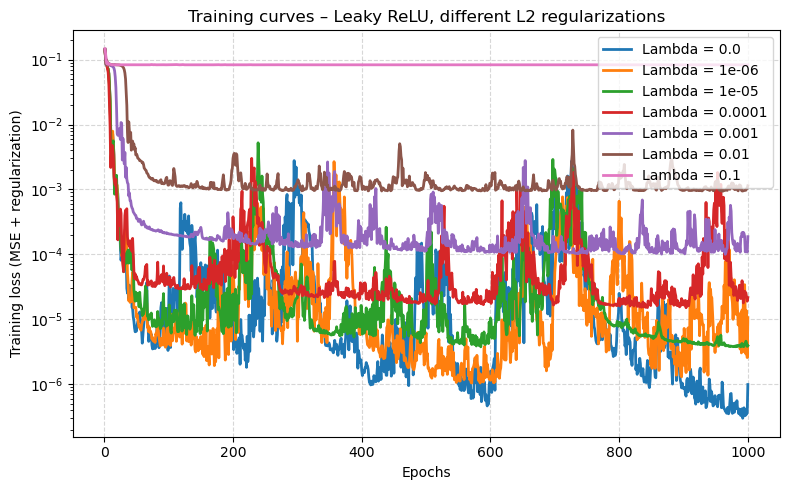

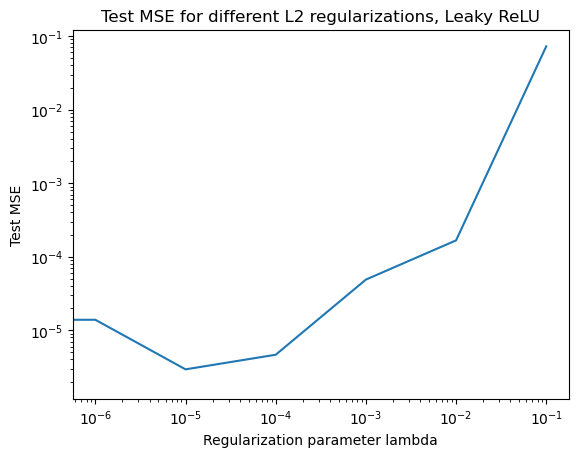

In [3]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lambdas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = 1e-2
epochs = 1000
batch_size = 32

# Empty lists
histories = []
MSEs = []

for lam in lambdas:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l2_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(lambdas)):
    print(f"Lambda={lambdas[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lam in zip(histories, lambdas):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"Lambda = {lam}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU, different L2 regularizations")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(lambdas, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Test MSE")
plt.title("Test MSE for different L2 regularizations, Leaky ReLU")
plt.show()
    


We see that the best regularization (excluding lam=0.0) is 1e-5. Will use this when comparing with Ridge regression from project 1

### Finding optimal learning rate

MSE on test data:
Learning Rate =0.0001, MSE = 0.07616662238730873
Learning Rate =0.0003, MSE = 0.07638691156208595
Learning Rate =0.001, MSE = 0.07616408449772924
Learning Rate =0.003, MSE = 1.258035193376711e-05
Learning Rate =0.01, MSE = 2.936544777016712e-06
Learning Rate =0.03, MSE = 2.263527044682414e-05


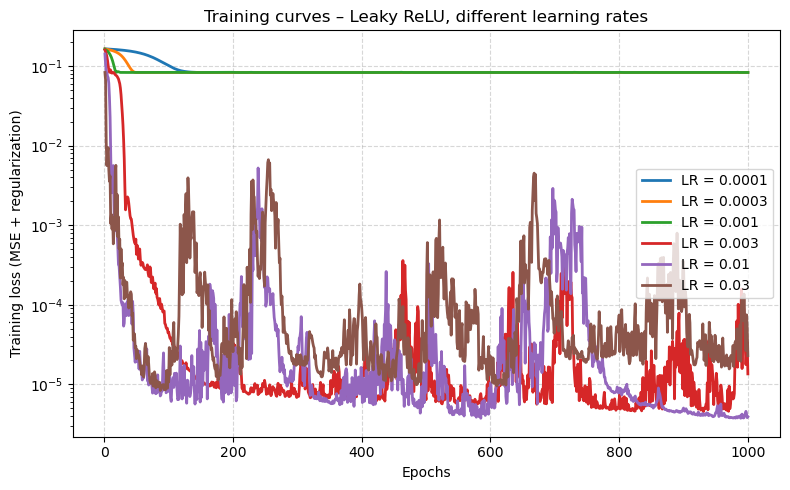

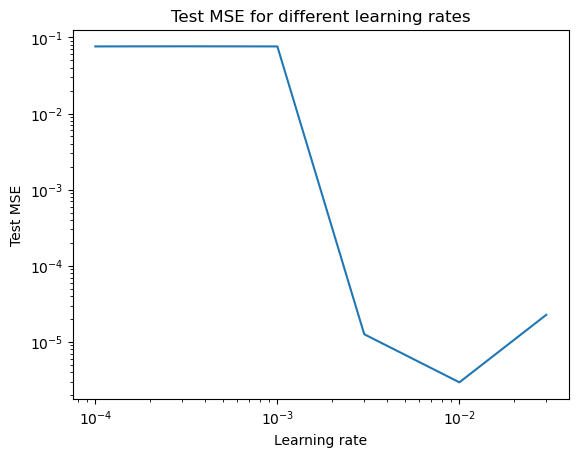

In [4]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-5
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
epochs = 1000
batch_size = 32

# Empty lists
histories = []
MSEs = []

for lr in learning_rates:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l2_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(learning_rates)):
    print(f"Learning Rate ={learning_rates[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lr in zip(histories, learning_rates):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"LR = {lr}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU, different learning rates")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(learning_rates, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Test MSE")
plt.title("Test MSE for different learning rates")
plt.show()
    


We see that the optimal learning rate (for this lambda) is 1e-2

### Finding optimal batch size

MSE on test data:
Batch size =4, MSE = 2.6580292910149585e-05
Batch size =16, MSE = 5.199082164480465e-06
Batch size =32, MSE = 2.936544777016712e-06
Batch size =64, MSE = 5.684742906913066e-06
Batch size =100, MSE = 8.567668940629309e-06


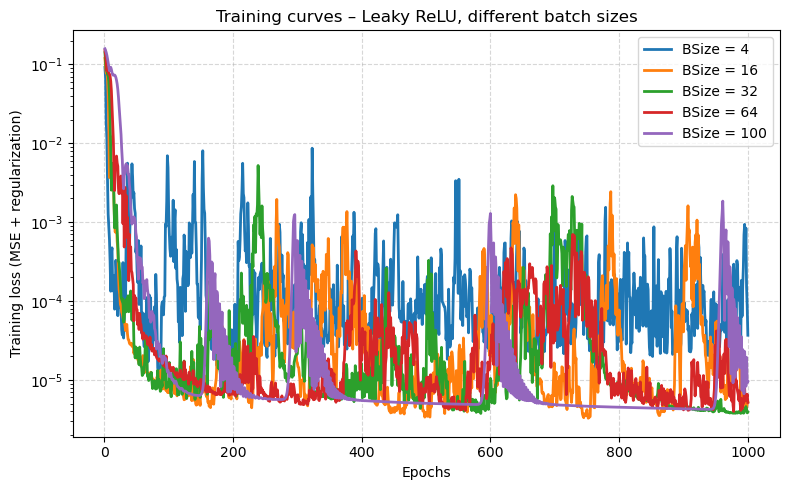

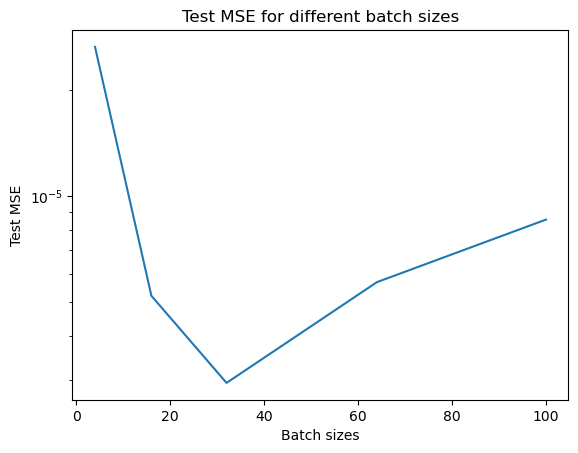

In [5]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-5
lr = 1e-2
epochs = 1000
batch_sizes = [4, 16, 32, 64, 100]

# Empty lists
histories = []
MSEs = []

for batch_size in batch_sizes:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l2_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(batch_sizes)):
    print(f"Batch size ={batch_sizes[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, batch_size in zip(histories, batch_sizes):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"BSize = {batch_size}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU, different batch sizes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(batch_sizes, MSEs)
plt.yscale("log")
plt.xlabel("Batch sizes")
plt.ylabel("Test MSE")
plt.title("Test MSE for different batch sizes")
plt.show()
    


We see that the optimal batch size for this learning rate and lambda

### Comparing with Ridge

Optimal Ridge params:

- Degree: 13
- Lambda: 1e-5

Optimal NN params (L2 regularization):

- Lambda: 1e-5
- Learning rate: 1e-2
- Batch size: 32

In [6]:
from Code_Project1.polynomial_features import polynomial_features
from Code_Project1.Ridge import Ridge_parameters

MSEs: 
Ridge regression MSE = 0.0018463473610311719
Neural Network MSE = 2.936544777016712e-06


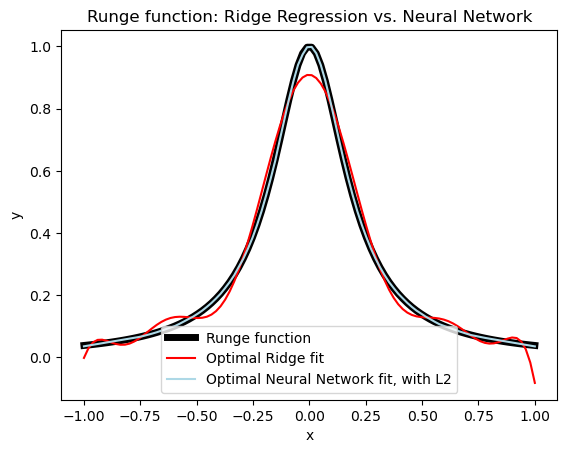

In [7]:
### Ridge Regression with optimal parameters ###
pol=13
lam=1e-5

X_train = polynomial_features(x_train.ravel(),pol, False)
X_test = polynomial_features(x_test.ravel(), pol, False)
X_plot = polynomial_features(x.ravel(), pol, False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_plot_s  = scaler.transform(X_plot)
y_offset = np.mean(y_train)

beta = Ridge_parameters(X_train_s, y_train, lambda_=lam)
y_pred_full_Ridge = X_plot_s@beta + y_offset
y_pred_test_Ridge = X_test_s@beta + y_offset
MSE_Ridge = mse(y_pred_test_Ridge, y_test)

### Neural network with optimal paramters ###
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-5
lr = 1e-2
epochs = 1000
batch_size = 32
nn = NeuralNetwork(network_input_size=1,
                    layer_output_sizes=layers,
                    activation_funcs=activations,
                    activation_ders=activation_ders,
                    cost_fun=mse,
                    cost_der=mse_deriv,
                    seed=seed,
                    l2_lambda=lam)
optimizer = Adam(lr=lr)
history = nn.fit(x_train_s,
                    y_train,
                    epochs = epochs,
                    batch_size=batch_size,
                    optimizer = optimizer,
                    log_every=None)
y_pred_full_nn = nn.predict(x_s)
y_pred_test_nn = nn.predict(x_test_s)
MSE_nn = mse(y_pred_test_nn, y_test)

### Printing MSEs ###
print("MSEs: ")
print(f"Ridge regression MSE = {MSE_Ridge}")
print(f"Neural Network MSE = {MSE_nn}")

### Plotting Fits ###
plt.plot(x, y, color="black", linewidth=5, label="Runge function")
plt.plot(x, y_pred_full_Ridge, color="red",label="Optimal Ridge fit")
plt.plot(x, y_pred_full_nn, color="lightblue",label="Optimal Neural Network fit, with L2")
plt.title("Runge function: Ridge Regression vs. Neural Network")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()




## Analyzing L1 regularization

### Finding optimal Lambda, L1

MSE on test data: (L1 regularization)
Lambda=0.0, MSE = 1.9561668417288353e-06
Lambda=1e-06, MSE = 3.4486156013023973e-05
Lambda=1e-05, MSE = 2.237104523542239e-05
Lambda=0.0001, MSE = 1.6902961777943205e-05
Lambda=0.001, MSE = 8.84455934624837e-05
Lambda=0.01, MSE = 0.07263081555715833
Lambda=0.1, MSE = 0.07262866708023938


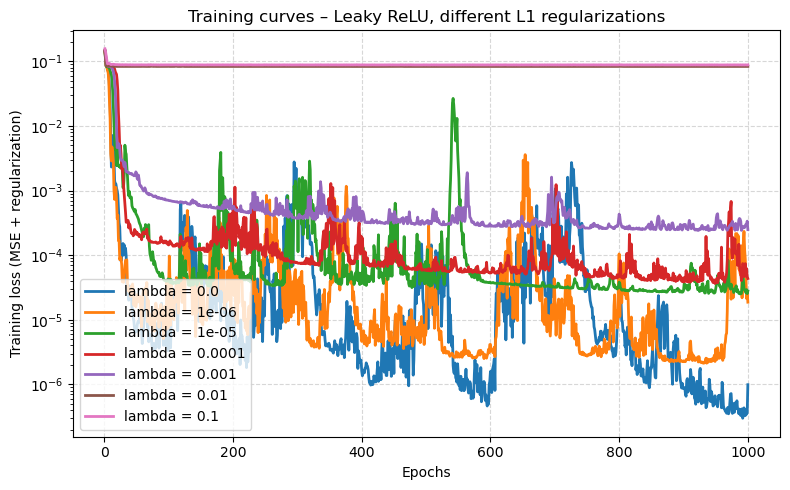

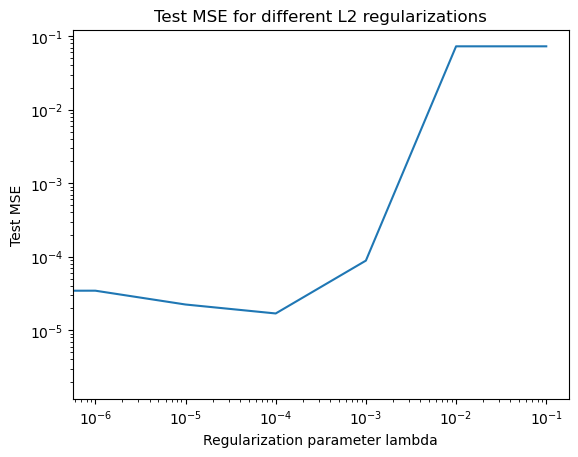

In [8]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lambdas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = 1e-2
epochs = 1000
batch_size = 32

# Empty lists
histories = []
MSEs = []

for lam in lambdas:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l1_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data: (L1 regularization)")
for i in range(len(lambdas)):
    print(f"Lambda={lambdas[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lam in zip(histories, lambdas):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"lambda = {lam}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU, different L1 regularizations")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(lambdas, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Test MSE")
plt.title("Test MSE for different L2 regularizations")
plt.show()
    


Optimal L1 regularization (excluding no regularization) is 1e-4, yielding MSE = 1.69e-5

### Finding optimal learning rate

MSE on test data:
Learning Rate =0.0001, MSE = 0.07602548361857335
Learning Rate =0.0003, MSE = 0.07458791150515662
Learning Rate =0.001, MSE = 2.108193793774963e-05
Learning Rate =0.005, MSE = 3.962874215165283e-05
Learning Rate =0.01, MSE = 1.6902961777943205e-05
Learning Rate =0.03, MSE = 2.5386523066305147e-05


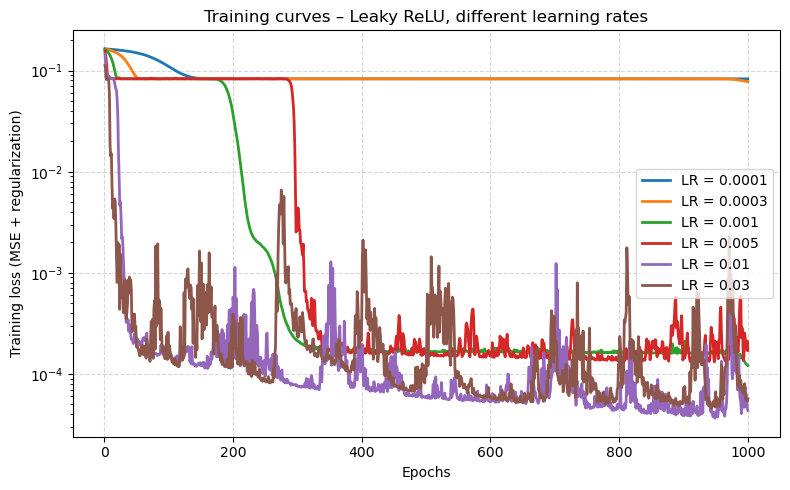

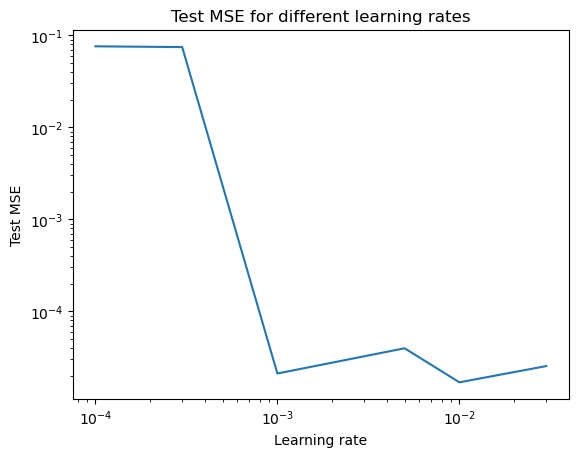

In [9]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-4
learning_rates = [1e-4, 3e-4, 1e-3, 5e-3, 1e-2, 3e-2]
epochs = 1000
batch_size = 32

# Empty lists
histories = []
MSEs = []

for lr in learning_rates:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l1_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(learning_rates)):
    print(f"Learning Rate ={learning_rates[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lr in zip(histories, learning_rates):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"LR = {lr}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU, different learning rates")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(learning_rates, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Test MSE")
plt.title("Test MSE for different learning rates")
plt.show()
    


Optimal learning rate is 1e-2, yielding MSE = 1.6902961777943205e-05

### Finding optimal batch size

MSE on test data:
Batch size =4, MSE = 3.9405779740794894e-05
Batch size =16, MSE = 3.9636670651102874e-05
Batch size =50, MSE = 6.224280106941658e-06
Batch size =64, MSE = 1.4029021533175898e-05
Batch size =100, MSE = 7.921242929836052e-06


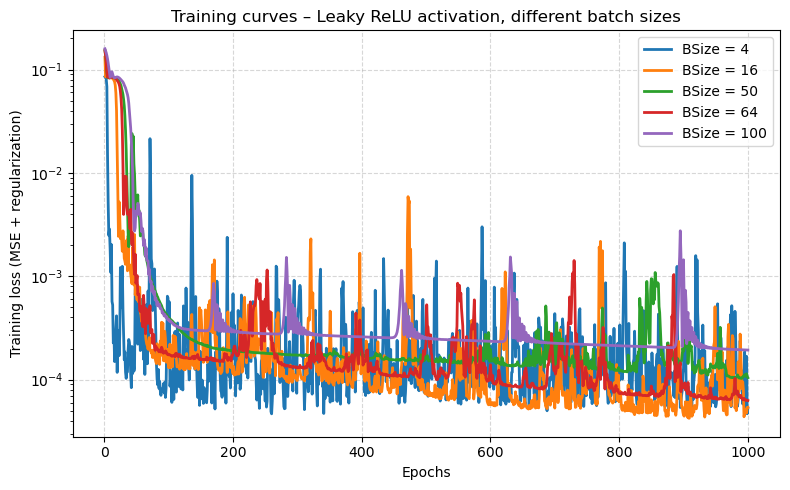

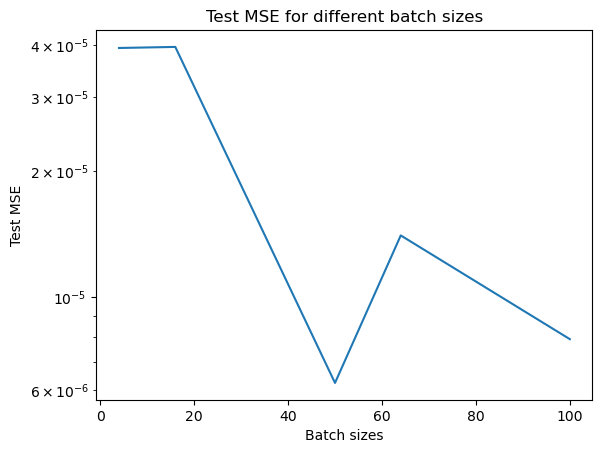

In [10]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-4
lr = 1e-2
epochs = 1000
batch_sizes = [4, 16, 50, 64, 100]

# Empty lists
histories = []
MSEs = []

for batch_size in batch_sizes:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l1_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(batch_sizes)):
    print(f"Batch size ={batch_sizes[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, batch_size in zip(histories, batch_sizes):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"BSize = {batch_size}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training loss (MSE + regularization)")
plt.title("Training curves – Leaky ReLU activation, different batch sizes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(batch_sizes, MSEs)
plt.yscale("log")
plt.xlabel("Batch sizes")
plt.ylabel("Test MSE")
plt.title("Test MSE for different batch sizes")
plt.show()
    


Optimal batch size is 50, improving the MSE to 6.224280106941658e-06

### Comparing with LASSO regression

Optimal LASSO params from project 1:

- lambda: 1e-5
- degree: 10

These values was found using scikitlearn in project 1, we will therefore compare our neural network with LASSO regression using Scikit learn.

Optimal NN params:

- Lambda: 1e-4
- learning rate: 1e-2
- Batch size: 50

In [11]:
from sklearn.linear_model import Lasso

MSEs: 
LASSO regression MSE = 0.14930231012849074
Neural Network MSE = 6.224280106941658e-06


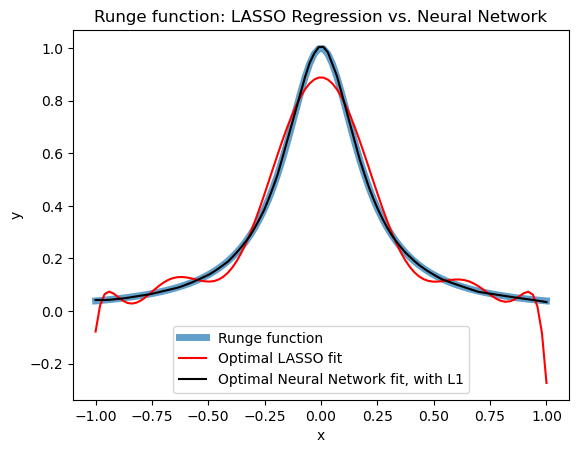

In [12]:
### Optimal LASSO regression ###
deg = 10
lam = 1e-5

X_train = polynomial_features(x_train.ravel(),pol, False)
X_test = polynomial_features(x_test.ravel(), pol, False)
X_plot = polynomial_features(x.ravel(), pol, False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_plot_s  = scaler.transform(X_plot)
y_offset = np.mean(y_train)

lasso = Lasso(alpha=lam, fit_intercept=False, max_iter=10000000)
lasso.fit(X_train_s, y_train)
beta_sklearn = lasso.coef_
y_pred_full_LASSO = X_plot_s@beta_sklearn + y_offset
y_pred_test_LASSO = X_test_s@beta_sklearn + y_offset
MSE_LASSO = mse(y_pred_test_LASSO, y_test)

### Neural network with optimal parameters ###
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-4
lr = 1e-2
epochs = 1000
batch_size = 50
nn = NeuralNetwork(network_input_size=1,
                    layer_output_sizes=layers,
                    activation_funcs=activations,
                    activation_ders=activation_ders,
                    cost_fun=mse,
                    cost_der=mse_deriv,
                    seed=seed,
                    l1_lambda=lam)
optimizer = Adam(lr=lr)
history = nn.fit(x_train_s,
                    y_train,
                    epochs = epochs,
                    batch_size=batch_size,
                    optimizer = optimizer,
                    log_every=None)
y_pred_full_nn = nn.predict(x_s)
y_pred_test_nn = nn.predict(x_test_s)
MSE_nn = mse(y_pred_test_nn, y_test)

### Printing MSEs ###
print("MSEs: ")
print(f"LASSO regression MSE = {MSE_LASSO}")
print(f"Neural Network MSE = {MSE_nn}")

### Plotting Fits ###
plt.plot(x, y, alpha = 0.7, linewidth=5, label="Runge function")
plt.plot(x, y_pred_full_LASSO, color="red",label="Optimal LASSO fit")
plt.plot(x, y_pred_full_nn, color="black",label="Optimal Neural Network fit, with L1")
plt.title("Runge function: LASSO Regression vs. Neural Network")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


